https://github.com/ThomasDelteil/DeepLearningWithMXNetGluon/blob/master/9_object_segmentation.ipynb

In [1]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.0

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x64924000 @  0x7f64e3a25615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 81kB 6.8MB/s 


In [2]:
!pip install gluoncv

     |████████████████████████████████| 1.0MB 12.3MB/s 
     |████████████████████████████████| 11.8MB 47.9MB/s 
     |████████████████████████████████| 317kB 54.7MB/s 
     |████████████████████████████████| 256kB 51.6MB/s 
     |████████████████████████████████| 675kB 47.6MB/s 
     |████████████████████████████████| 215kB 58.8MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 972kB 42.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 2.6MB 45.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 962kB 44.0MB/s 
     |████████████████████████████████| 7.2MB 47.1MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
  Created wheel for ConfigSpace: fi

中间有import被删了。。

In [4]:
!pip install mxboard

     |████████████████████████████████| 51kB 5.3MB/s 


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import random, multiprocessing, time

import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from mxnet import gluon, autograd
from mxnet.gluon import nn

from mxboard import SummaryWriter

import numpy as np

import gluoncv
from gluoncv.utils.parallel import *
from gluoncv.utils.viz import get_color_pallete, DeNormalize

https://blog.csdn.net/weixin_41278720/article/details/83472401

In [6]:
_TARGET_DIR = os.path.expanduser('usr/.mxnet/datasets/voc')

NameError: ignored

In [7]:
"""Prepare PASCAL VOC datasets"""
import os
import shutil
import argparse
import tarfile
from gluoncv.utils import download, makedirs

In [8]:
_TARGET_DIR = os.path.expanduser('usr/.mxnet/datasets/voc')

In [9]:
# Download and extract VOC datasets into ``path``
 
def download_voc(path, overwrite=False):
    _DOWNLOAD_URLS = [
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
         '34ed68851bce2a36e2a223fa52c661d592c66b3c'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
         '41a8d6e12baa5ab18ee7f8f8029b9e11805b4ef1'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
         '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')]
    makedirs(path)
    for url, checksum in _DOWNLOAD_URLS:
        filename = download(url, path=path, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with tarfile.open(filename) as tar:
            tar.extractall(path=path)

In [10]:

#####################################################################################
# Download and extract the VOC augmented segmentation dataset into ``path``
 
def download_aug(path, overwrite=False):
    _AUG_DOWNLOAD_URLS = [
        ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz', '7129e0a480c2d6afb02b517bb18ac54283bfaa35')]
    makedirs(path)
    for url, checksum in _AUG_DOWNLOAD_URLS:
        filename = download(url, path=path, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with tarfile.open(filename) as tar:
            tar.extractall(path=path)
            shutil.move(os.path.join(path, 'benchmark_RELEASE'),
                        os.path.join(path, 'VOCaug'))
            filenames = ['VOCaug/dataset/train.txt', 'VOCaug/dataset/val.txt']
            # generate trainval.txt
            with open(os.path.join(path, 'VOCaug/dataset/trainval.txt'), 'w') as outfile:
                for fname in filenames:
                    fname = os.path.join(path, fname)
                    with open(fname) as infile:
                        for line in infile:
                            outfile.write(line)

In [11]:
path = os.path.expanduser('usr/.mxnet/datasets/voc')

In [12]:
if not os.path.isdir(path) or not os.path.isdir(os.path.join(path, 'VOC2007')) \
    or not os.path.isdir(os.path.join(path, 'VOC2012')):
    download_voc(path)
    shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2007'), os.path.join(path, 'VOC2007'))
    shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2012'), os.path.join(path, 'VOC2012'))
    shutil.rmtree(os.path.join(path, 'VOCdevkit'))

100%|██████████| 449250/449250 [00:30<00:00, 14910.13KB/s]


100%|██████████| 440450/440450 [00:29<00:00, 15181.66KB/s]


100%|██████████| 1952773/1952773 [02:05<00:00, 15569.00KB/s]


In [13]:
nclasses = len(gluoncv.data.VOCSegmentation('usr/.mxnet/datasets/voc').classes)

In [14]:
class FCN(nn.HybridBlock):
    def __init__(self, resnet_backbone, nclass):
        super(FCN, self).__init__()
        self.backbone = resnet_backbone 
        in_channels = 2048
        with self.name_scope():
            self.head = nn.HybridSequential()
            inter_channels = in_channels // 4
            self.head.add(nn.Conv2D(in_channels=in_channels, channels=inter_channels,
                                     kernel_size=3, padding=1))
            self.head.add(nn.BatchNorm(in_channels=inter_channels))
            self.head.add(nn.Activation('relu'))
            self.head.add(nn.Dropout(0.1))
            self.head.add(nn.Conv2D(in_channels=inter_channels, channels=nclass,
                                     kernel_size=1))
        
    def hybrid_forward(self, F, x):
        # run through backbone
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        c3 = self.backbone.layer3(x)
        c4 = self.backbone.layer4(c3)

        #run through head
        y = self.head(c4)

        #resize
        y = F.contrib.BilinearResize2D(y, height=480,width=480)
        return y

In [15]:
ctx_list = [mx.gpu(i) for i in range(4)]
backbone = gluoncv.model_zoo.resnet50_v1b(root='usr/.mxnet/models',pretrained=True, dilated=True, ctx=ctx_list)
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.load_parameters().setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=ctx_list)

100%|██████████| 55344/55344 [00:00<00:00, 76134.56KB/s]


MXNetError: ignored

单GPU

In [16]:
backbone = gluoncv.model_zoo.resnet50_v1b(root='usr/.mxnet/models',pretrained=True, dilated=True, ctx=mx.gpu(0))
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.load_parameters().setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

TypeError: ignored

In [17]:
backbone = gluoncv.model_zoo.resnet50_v1b(root='usr/.mxnet/models',pretrained=True, dilated=True, ctx=mx.gpu(0))
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.load_parameters("usr/net.params").setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

AssertionError: ignored

In [18]:
backbone = gluoncv.model_zoo.resnet50_v1b(root='usr/.mxnet/models',pretrained=True, dilated=True, ctx=mx.gpu(0))
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.load_parameters("usr/net.params", allow_missing=True).setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

AssertionError: ignored

In [19]:
backbone = gluoncv.model_zoo.resnet50_v1b(root='usr/.mxnet/models',pretrained=True, dilated=True, ctx=mx.gpu(0))
del backbone.fc

net = FCN(backbone, nclasses)

# Initialize the head
net.head.collect_params().setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

In [20]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [21]:
trainset = gluoncv.data.VOCSegmentation(split='train', transform=input_transform)
print(len(trainset))
valset = gluoncv.data.VOCSegmentation(split='val', transform=input_transform)
print(len(valset))

OSError: ignored

In [22]:
trainset = gluoncv.data.VOCSegmentation('usr/.mxnet/datasets/voc',split='train', transform=input_transform)
print(len(trainset))
valset = gluoncv.data.VOCSegmentation('usr/.mxnet/datasets/voc',split='val', transform=input_transform)
print(len(valset))

2913
1449


In [23]:
batch_size = 32
# Create Training Loader
train_data = gluon.data.DataLoader(trainset, batch_size, shuffle=True, last_batch='rollover', 
                                   num_workers=multiprocessing.cpu_count()-5)
val_data = gluon.data.DataLoader(valset, batch_size, shuffle=False, last_batch='discard', 
                                   num_workers=multiprocessing.cpu_count()-5)

In [24]:
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]

mask = get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

# denormalize the image
img = DeNormalize([-.485, -.456, -.406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

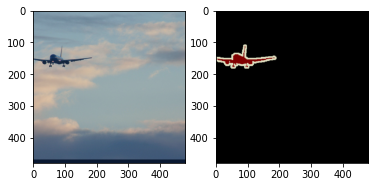

In [25]:
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)

# subplot 2 for the mask
fig.add_subplot(1,2,2)
plt.imshow(mask)

# display
plt.show()

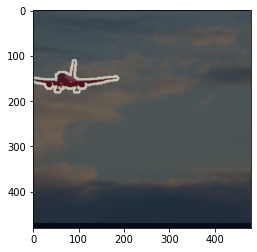

In [26]:
plt.imshow(((mask+img)/2).astype(int))

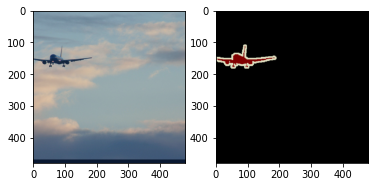

In [27]:
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)

# subplot 2 for the mask
fig.add_subplot(1,2,2)
plt.imshow(mask)

# display
plt.show()

In [28]:
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]

mask = get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

# denormalize the image
img = DeNormalize([-.485, -.456, -.406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

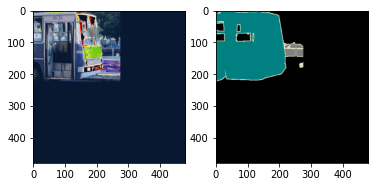

In [29]:
# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)

# subplot 2 for the mask
fig.add_subplot(1,2,2)
plt.imshow(mask)

# display
plt.show()

In [30]:
from gluoncv.model_zoo.segbase import SoftmaxCrossEntropyLossWithAux
criterion = SoftmaxCrossEntropyLossWithAux(aux=False)

ImportError: ignored

In [31]:
from gluoncv.loss import SoftmaxCrossEntropyLossWithAux
criterion = SoftmaxCrossEntropyLossWithAux(aux=False)

ImportError: ignored

In [32]:
from gluoncv.loss import SoftmaxCrossEntropyLoss
criterion = SoftmaxCrossEntropyLoss()

In [33]:
epochs = 50

In [34]:
epochs = 5

model = DataParallelModel(net, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

In [35]:
lr_scheduler = gluoncv.utils.LRScheduler('step', 
                                         0.001*len(ctx_list), 
                                         len(train_data), 
                                         epochs, 
                                         step=(10,30,40), 
                                         warmup_epochs=2, 
                                         warmup_lr=0.001)

TypeError: ignored

In [36]:
lr_scheduler = gluoncv.utils.LRScheduler('step', 
                                         0.001*1, 
                                         len(train_data), 
                                         epochs, 
                                         step=(10,30,40), 
                                         warmup_epochs=2, 
                                         warmup_lr=0.001)

TypeError: ignored

In [37]:
lr_scheduler = gluoncv.utils.LRScheduler('step', 
                                         0.001*1, 
                                         len(train_data), 
                                         epochs, 
                                         step_iter=(10,30,40), 
                                         step_epoch=2, 
                                         step_factor=0.001)

In [38]:
optimizer = gluon.Trainer(net.collect_params(), 'sgd',
                          {'lr_scheduler': lr_scheduler,
                           'wd':0.0001,
                           'momentum': 0.95,
                           'multi_precision': True})


In [39]:
def get_images(outputs, data, target):
    outputs_images = outputs[0][0].argmax(1).asnumpy()
    outputs_images = [get_color_pallete(mask, dataset='pascal_voc') for mask in outputs_images]
    outputs_images = [np.expand_dims(np.array(mask.convert('RGB'), dtype=np.int), 0) for mask in outputs_images]
    outputs_images = np.concatenate(outputs_images)[:3]
    outputs_images = outputs_images.transpose((0, 3, 1, 2)).astype(np.uint8)

    target_images = target[:3,:,:]
    target_images = [get_color_pallete(mask.asnumpy(), dataset='pascal_voc') for mask in target_images]
    target_images = [np.expand_dims(np.array(mask.convert('RGB'), dtype=np.int), 0) for mask in target_images]
    target_images = np.concatenate(target_images).transpose((0, 3, 1, 2)).astype(np.uint8)

    data_images = data[:3,:,:,:]
    data_images = DeNormalize([-.485, -.456, -.406], [.229, .224, .225])(data_images)
    data_images = (data_images.asnumpy()*255).astype(np.uint8).astype(np.uint8)
    
    return outputs_images, target_images, data_images

In [40]:
n_batch = 5
train_loss = 0.0
for e in range(epochs):
    tick = time.time()
    train_loss = 0
    
    # Train
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i, e)
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            autograd.backward(losses)
        optimizer.step(batch_size, ignore_stale_grad=True)        
        
        if i % 10 == 0:
            for loss in losses:
                train_loss += loss.mean().asnumpy() / len(losses)
    
    # Val
    val_loss = 0
    for j, (data, target) in enumerate(val_data):
        outputs = model(data)
        losses = criterion(outputs, target)
        for loss in losses:
            val_loss += loss.mean().asnumpy() / len(losses)

            
    print("Epoch[{}]|Time {:.2f}s|Batch[{}]|Train Loss:{:.2f}|Val Loss:{:.2f}".format(
        e, time.time()-tick, i, train_loss[0]/(i+1), val_loss[0]/(j+1))
         )                                                          
                                                          
    # print images
    pred_images, target_images, data_images = get_images(outputs, data, target)
    with SummaryWriter(logdir='/data/logs/run1') as sw:
        sw.add_image(tag='data_image', image=data_images, global_step=e)
        sw.add_image(tag='pred_image', image=(pred_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_image(tag='target_image', image=(target_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_scalar(tag='loss', value={'test':val_loss[0]/(j+1)}, global_step=e)
        sw.add_scalar(tag='loss', value={'train':train_loss[0]/(i+1)}, global_step=e)

TypeError: ignored

In [41]:
n_batch = 5
train_loss = 0.0
for e in range(epochs):
    tick = time.time()
    train_loss = 0
    
    # Train
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i)
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            autograd.backward(losses)
        optimizer.step(batch_size, ignore_stale_grad=True)        
        
        if i % 10 == 0:
            for loss in losses:
                train_loss += loss.mean().asnumpy() / len(losses)
    
    # Val
    val_loss = 0
    for j, (data, target) in enumerate(val_data):
        outputs = net(data)
        losses = criterion(outputs, target)
        for loss in losses:
            val_loss += loss.mean().asnumpy() / len(losses)

            
    print("Epoch[{}]|Time {:.2f}s|Batch[{}]|Train Loss:{:.2f}|Val Loss:{:.2f}".format(
        e, time.time()-tick, i, train_loss[0]/(i+1), val_loss[0]/(j+1))
         )                                                          
                                                          
    # print images
    pred_images, target_images, data_images = get_images(outputs, data, target)
    with SummaryWriter(logdir='/data/logs/run1') as sw:
        sw.add_image(tag='data_image', image=data_images, global_step=e)
        sw.add_image(tag='pred_image', image=(pred_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_image(tag='target_image', image=(target_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_scalar(tag='loss', value={'test':val_loss[0]/(j+1)}, global_step=e)
        sw.add_scalar(tag='loss', value={'train':train_loss[0]/(i+1)}, global_step=e)

RuntimeError: ignored

In [42]:
# Initialize the head
net.head.load_parameters(ctx=mx.gpu(0)).setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

TypeError: ignored

In [43]:
# Initialize the head
net.head.collect_params().setattr('lr_mult', 10)
net.head.initialize(mx.init.Xavier(), ctx=mx.gpu(0))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'fcn3_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'fcn3_conv0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'fcn3_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'fcn3_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/

In [44]:
n_batch = 5
train_loss = 0.0
for e in range(epochs):
    tick = time.time()
    train_loss = 0
    
    # Train
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i)
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            autograd.backward(losses)
        optimizer.step(batch_size, ignore_stale_grad=True)        
        
        if i % 10 == 0:
            for loss in losses:
                train_loss += loss.mean().asnumpy() / len(losses)
    
    # Val
    val_loss = 0
    for j, (data, target) in enumerate(val_data):
        outputs = net(data)
        losses = criterion(outputs, target)
        for loss in losses:
            val_loss += loss.mean().asnumpy() / len(losses)

            
    print("Epoch[{}]|Time {:.2f}s|Batch[{}]|Train Loss:{:.2f}|Val Loss:{:.2f}".format(
        e, time.time()-tick, i, train_loss[0]/(i+1), val_loss[0]/(j+1))
         )                                                          
                                                          
    # print images
    pred_images, target_images, data_images = get_images(outputs, data, target)
    with SummaryWriter(logdir='/data/logs/run1') as sw:
        sw.add_image(tag='data_image', image=data_images, global_step=e)
        sw.add_image(tag='pred_image', image=(pred_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_image(tag='target_image', image=(target_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_scalar(tag='loss', value={'test':val_loss[0]/(j+1)}, global_step=e)
        sw.add_scalar(tag='loss', value={'train':train_loss[0]/(i+1)}, global_step=e)

RuntimeError: ignored

In [45]:
net.to(mx.gpu(0))

AttributeError: ignored

In [46]:
net=net(ctx=mx.gpu(0))

TypeError: ignored

In [47]:
n_batch = 5
train_loss = 0.0
for e in range(epochs):
    tick = time.time()
    train_loss = 0
    
    # Train
    for i, (data, target) in enumerate(train_data):
        lr_scheduler.update(i)
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            autograd.backward(losses)
        optimizer.step(batch_size, ignore_stale_grad=True)        
        
        if i % 10 == 0:
            for loss in losses:
                train_loss += loss.mean().asnumpy() / len(losses)
    
    # Val
    val_loss = 0
    for j, (data, target) in enumerate(val_data):
        outputs = net(data)
        losses = criterion(outputs, target)
        for loss in losses:
            val_loss += loss.mean().asnumpy() / len(losses)

            
    print("Epoch[{}]|Time {:.2f}s|Batch[{}]|Train Loss:{:.2f}|Val Loss:{:.2f}".format(
        e, time.time()-tick, i, train_loss[0]/(i+1), val_loss[0]/(j+1))
         )                                                          
                                                          
    # print images
    pred_images, target_images, data_images = get_images(outputs, data, target)
    with SummaryWriter(logdir='/data/logs/run1') as sw:
        sw.add_image(tag='data_image', image=data_images, global_step=e)
        sw.add_image(tag='pred_image', image=(pred_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_image(tag='target_image', image=(target_images*0.7+0.3*data_images).astype(np.uint8), global_step=e)
        sw.add_scalar(tag='loss', value={'test':val_loss[0]/(j+1)}, global_step=e)
        sw.add_scalar(tag='loss', value={'train':train_loss[0]/(i+1)}, global_step=e)

RuntimeError: ignored

In [48]:
train_data